In this notebook, I will use fastai library to create and train a Convolutional Neural Network.

# Importing libraries

In [ ]:
#hide 
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     |████████████████████████████████| 727kB 21.2MB/s 
     |████████████████████████████████| 194kB 56.6MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 1.1MB 55.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 40kB 7.0MB/s 
     |████████████████████████████████| 92kB 13.3MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 2.6MB 37.2MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *
import seaborn as sns
from fastai.vision import * 
from sklearn.model_selection import train_test_split
from fastai.callback.all import *

# Loading Dataset 

In [ ]:
data = pd.read_csv('gdrive/My Drive/age_gender.csv', delimiter=',')

In [ ]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


In [ ]:
data.head(1)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 14...


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


# Distributions 

So, there are three targets:

*  Age: range from 1 to 116
* Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other
* Gender: 0 - male, 1 - female 



In [ ]:
import plotly.graph_objects as go
## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

##Age distribution

In [ ]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

##Ethnicity distribution

In [ ]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

## Gender Distribution

In [ ]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

# Data preparation

Before I can feed "pixels" to my Convolution network:

*   Pixels are saved as one long String separated with spaces, I need to transform every 1D 2048 to 2D 48 x 48 (CNN requirement), also I need to add one more dimension(Pytorch requirement)   
*   Split data into training and validation set (Neural network requirement)
*   Convert training and validation set to tensors (Pytorch requirement, performance benefit)
*   Put training and validation set into TensorDataset (Pytorch requirement)
*   Put TensorDatasets into TransformedDataLoaders and wrap it using DataLoaders


In [ ]:
def matrix_to_color_matrix(words):
    frames = np.zeros((3,words.shape[0], words.shape[1]))
    for i in range(words.shape[0]):
        for j in range(words.shape[1]):
            frames[:,i, j] = [words[i][j],words[i][j],words[i][j]]
    return frames

def pixel_array_to_matrix(pixels, frm, to, rows, columns):
    numpy = [0 for i in range(to)]
    for i in range(len(numpy)):
        numpy[i] = pixels[i]
    return np.array(numpy).reshape(rows, columns)

In [ ]:
X=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32") )/255.0 #normalization
print(X.shape)
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48))
print(X[1].shape)

list_of_pictures = []
for i in range(X.shape[0]):
  list_of_pictures.append(matrix_to_color_matrix(X[i]))

X = np.array(list_of_pictures)

print(X.shape)

(23705,)
(48, 48)
(23705, 3, 48, 48)


In [ ]:
print(X[0].shape)

(3, 48, 48)


In [ ]:
# # multiple rows with one long string(2304 numbers) separated with spaces, 
# X=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))/255.0 #normalization
# X

# X = np.stack(np.array(X), axis=0)
# X = np.reshape(X, (-1, 48, 48))
# X = np.expand_dims(X, axis=1)

# X.shape

In [ ]:
# y = data['age'].values
# y= data['ethnicity'].values
# y = data['gender'].values

y=[]
for age,gender,ethnicity in zip(np.log(data['age'].values)/4.75,  data['gender'].values, data['ethnicity'].values):
  y.append([age,gender,ethnicity])

# dt=np.dtype('float,int,int')
y=np.array(y)
print(y)

x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15
)

[[0.         0.         2.        ]
 [0.         0.         2.        ]
 [0.         0.         2.        ]
 ...
 [0.96739365 1.         2.        ]
 [0.96739365 1.         2.        ]
 [0.96739365 1.         0.        ]]


In [ ]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train)
# y_train = y_train.squeeze()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid)
# y_valid = y_valid.squeeze()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(y_valid)

torch.Size([20149, 3, 48, 48])
torch.Size([20149, 3])
torch.Size([3556, 3, 48, 48])
torch.Size([3556, 3])
tensor([[0.8193, 1.0000, 1.0000],
        [0.7713, 0.0000, 1.0000],
        [0.4378, 0.0000, 4.0000],
        ...,
        [0.6691, 0.0000, 0.0000],
        [0.8014, 0.0000, 3.0000],
        [0.7160, 0.0000, 0.0000]], dtype=torch.float64)


In [ ]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [ ]:
BATCH_SIZE = 32

train_dl = TfmdDL(train_ds, bs=BATCH_SIZE, shuffle=False)
valid_dl = TfmdDL(valid_ds, bs=2*BATCH_SIZE)

xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([32, 3, 48, 48]), torch.Size([32, 3]))

# Sample images

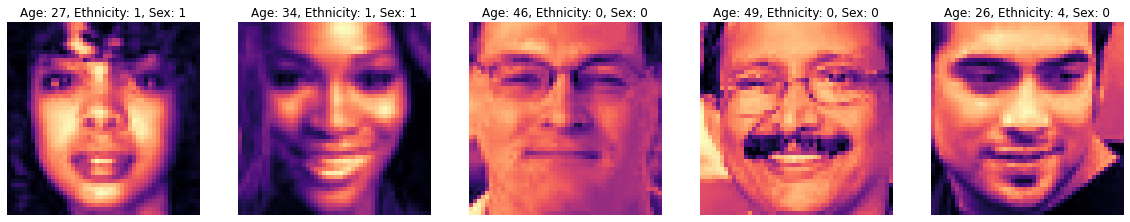

In [ ]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(data))
    
    age = data['age'][random_face]
    ethnicity = data['ethnicity'][random_face]
    gender = data['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(X[random_face][0], cmap=plt.get_cmap('magma'))
    axes[i].axis('off')

# df = pd.DataFrame(x_valid[0][0])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
# show_image(x_valid[100][0], figsize=(2,2), title="Age:"+str(data['age'].iloc[i])+" Ethnicity:"+str(data['ethnicity'].iloc[i])+" Gender:"+ str(data['gender'].iloc[i]))

In [ ]:
if torch.cuda.is_available():
    dls = DataLoaders(train_dl, valid_dl).cuda()
else:
    dls = DataLoaders(train_dl, valid_dl)

# Model

## Model definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855
class MultiTaskModel(nn.Module):
    """
    Creates a MTL model with the encoder from "arch" and with dropout multiplier ps.
    """
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_body(arch)        #fastai function that creates an encoder given an architecture
        self.fc1 = create_head(1024,1,ps=ps)    #fastai function that creates a head
        self.fc2 = create_head(1024,2,ps=ps)
        self.fc3 = create_head(1024,5,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)

        return  age, gender, ethnicity
        

class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, age):

        print("predictions",preds)
        print("age",age[0])
        mse, crossEntropy = MSELossFlat(), CrossEntropyLossFlat()
        
        # loss0 = mse(preds[0][0], age[0])
        # loss1 = crossEntropy(preds[0][1],age[1])
        # loss2 = crossEntropy(preds[2][2],age[2])

        # precision0 = torch.exp(-self.log_vars[0])
        # loss0 = precision0*loss0 + self.log_vars[0]

        # precision1 = torch.exp(-self.log_vars[1])
        # loss1 = precision1*loss1 + self.log_vars[1]

        # precision2 = torch.exp(-self.log_vars[2])
        # loss2 = precision2*loss2 + self.log_vars[2]
        
        return 1



# # popis cnn https://www.kaggle.com/androbomb/using-cnn-to-classify-images-w-pytorch
# class Mnist_NN(nn.Module):
#     def __init__(self):
#         super(Mnist_NN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # notice the padding
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # again...
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # again...
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1) # again...
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.fc1 = nn.Linear(64*6*6, 256) # it is 64....
#         self.fc2 = nn.Linear(256, 5)
#         self.dropout = torch.nn.Dropout(p=0.1)
#         self.relu = torch.nn.ReLU()

#     def forward(self, x):
#         # In the forward function, pass the data through the layers we defined in the init function
        
#         # Use a ReLU activation function after layer 1 (convolution 1 and pool)
#         x = F.relu(self.pool(self.conv1(x))) 
        
#         # Use a ReLU activation function after layer 2
#         x = F.relu(self.pool(self.conv2(x)))       

#         # Use a ReLU activation function after layer 2
#         x = F.relu(self.pool(self.conv3(x)))        
        
#         x = F.relu(self.conv4(x))      
#         # Select some features to drop to prevent overfitting (only drop during training)
#         x = F.dropout(self.dropout(x), training=self.training)
        
#         # Flatten
#         x = x.view(-1, 6 * 6 * 64)
#         # Feed to fully-connected layer to predict class
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         # Return class probabilities via a log_softmax function 
#         return x

In [ ]:
# Check if model parameters have been set correctly

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(models.resnet34).float().to(device)
summary(model, input_size=(3,48, 48))


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Mnist_NN().float().to(device)
# summary(model, input_size=(1, 48, 48))

In [ ]:
def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0], age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

model = MultiTaskModel(models.resnet34, ps=0.25).to(dls.device)

loss_func = MultiTaskLossWrapper(3).to(dls.device) #just making sure the loss is on the gpu

learn = Learner(dls, model, loss_func=loss_func, metrics=metrics )

#first I'll train only the last layer group (the heads)
learn.freeze()

## Model training



In [ ]:
import torch.optim as optim

# loss_func = nn.CrossEntropyLoss()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Mnist_NN().float()
# model.to(device)
# learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy, opt_func=SGD)

In [ ]:
learn.lr_find()

predictions (tensor([[0.3084],
        [0.5065],
        [0.7065],
        [0.5357],
        [0.8071],
        [0.1736],
        [0.6120],
        [0.2867],
        [0.6284],
        [0.4204],
        [0.3601],
        [0.3337],
        [0.4660],
        [0.4945],
        [0.4171],
        [0.1706],
        [0.6257],
        [0.3923],
        [0.4426],
        [0.6905],
        [0.4030],
        [0.4889],
        [0.6812],
        [0.8236],
        [0.4953],
        [0.4463],
        [0.3933],
        [0.4095],
        [0.4797],
        [0.4320],
        [0.4783],
        [0.8904]], device='cuda:0', grad_fn=<SigmoidBackward>), tensor([[ 0.1820,  0.1663],
        [-1.0645, -0.3358],
        [-0.0074, -0.2883],
        [-0.5542, -0.9292],
        [ 0.2479,  0.8207],
        [-1.0754, -0.0018],
        [ 0.4443,  0.0179],
        [-0.4246,  0.3871],
        [ 0.0445,  0.6074],
        [ 0.0259, -1.0300],
        [ 1.6478,  0.3662],
        [ 0.9239,  0.8793],
        [-0.2789,  1.7397],
 

AttributeError: ignored

In [ ]:
learn.unfreeze()
learn.model_dir = "/kaggle/working"

# if GPU enabled:
if torch.cuda.is_available():
    learn.model.cuda()

# learn.fit_one_cycle(10, 5e-2, callbacks=[SaveModelCallback(every='improvement', monitor='validation_loss', name='best_saved')])
learn.fit_one_cycle(10, 0.5 )

predictions (tensor([[0.6483],
        [0.3796],
        [0.4811],
        [0.2864],
        [0.5202],
        [0.5026],
        [0.3765],
        [0.3595],
        [0.2865],
        [0.4494],
        [0.4903],
        [0.2722],
        [0.4002],
        [0.3593],
        [0.4216],
        [0.7740],
        [0.6490],
        [0.6013],
        [0.5929],
        [0.3822],
        [0.3571],
        [0.7504],
        [0.3737],
        [0.4882],
        [0.7587],
        [0.5829],
        [0.2583],
        [0.6192],
        [0.6822],
        [0.4783],
        [0.6225],
        [0.6702]], device='cuda:0', grad_fn=<SigmoidBackward>), tensor([[-0.3672, -0.1261],
        [-0.0916, -0.1339],
        [-0.0882,  0.5452],
        [ 0.4973,  0.8899],
        [ 1.1851, -0.7599],
        [-0.7070, -0.9721],
        [ 0.1244,  0.2044],
        [-0.7771,  0.4543],
        [ 1.0779, -2.1104],
        [-0.9278,  0.3423],
        [-0.5134,  0.3549],
        [-0.0156,  0.3734],
        [-0.2220, -2.0727],
 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([3])) that is different to the input size (torch.Size([160])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



RuntimeError: ignored

In [ ]:
learn.lr_find()

## Model testing

In [ ]:
valid_ds = TensorDataset(x_valid, y_valid)

In [ ]:
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
# Submit to kaggle:
if torch.cuda.is_available():
    X_test = x_valid.float().cuda()
else:
    X_test = torch.from_numpy(x_valid).float()
  
print(X_test.shape[0])
learn.freeze()

# yp = np.zeros((3555 ,2), dtype='int')
# for i in range(0, 3555, 5):
#     prob_sum = torch.argmax(F.softmax(learn.model(X_test[i:i+5]), dim=1), dim=1).cpu().numpy()
#     yp[i:i+5] = np.array(np.vstack([np.arange(i+1, i+5+1), prob_sum]).T)

yp = np.zeros((X_test.shape[0] ,2), dtype='int')
for i in range(0, X_test.shape[0], 1):
    prob_sum = torch.argmax(learn.model(X_test[i:i+1]), dim=1).cpu().numpy()
    yp[i:i+1] = np.array(np.vstack([np.arange(i+1, i+1+1), prob_sum]).T)

    
res = pd.DataFrame(yp, index = np.arange(len(yp)), columns=["ImageId", "Pred_gen"])
res.to_csv("submission.csv", index=False)
res

In [ ]:
res.Pred_gen.agg(['count', 'size', 'nunique'])
res.Pred_gen.value_counts()

In [ ]:
new_results=res.copy()
new_results.insert(2, "Real_gen", y_valid, True) 

In [ ]:
print(res)
print(new_results)

In [ ]:
new_results['que'] = np.where((new_results['Pred_gen'] == new_results['Real_gen']), 1, 0)
Total = new_results['que'].sum()
print(new_results)
print(Total)
print(2671/3556)

In [ ]:
# cannot use gpu when drawing pictures like this
X_test = Tensor.cpu(X_test)

# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(y_valid))
    
    gender_real = y_valid[random_face]
    gender_predicted = pd.DataFrame.to_numpy(res)[:, -1][random_face]
    
    axes[i].set_title('eth: {0}, eth_Predicted: {1}'.format(gender_real,gender_predicted))
    axes[i].imshow(x_valid[random_face][0], cmap=plt.get_cmap('magma'))
    axes[i].axis('off')

# df = pd.DataFrame(x_valid[0][0])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
# show_image(x_valid[100][0], figsize=(2,2), title="Age:"+str(data['age'].iloc[i])+" Ethnicity:"+str(data['ethnicity'].iloc[i])+" Gender:"+ str(data['gender'].iloc[i]))